In [1]:
# Import Data handling/display libraries
import pandas            as pd
import numpy             as np
import seaborn           as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
from IPython.display         import display
from typing                  import List, Union, Dict
# Import scikit-learn core slibraries
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics         import auc, roc_auc_score, roc_curve 
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
# Import IBM's AI Fairness tooolbox
from aif360.datasets         import BinaryLabelDataset  # To handle the data
from aif360.metrics          import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers       import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing  # Preprocessing technique
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Adult dataset
Adult_df= pd.read_csv('./input/adult-cleaned.csv')

In [3]:
# The AIF demo drops the following columns - we'll try the same
#train.drop(["Fnlwgt", "NativeCountry", "Relationship", "MaritalStatus"],axis=1,inplace=True)
Adult_df.drop(["Fnlwgt"],axis=1,inplace=True)

In [4]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'Gender'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'Income'
fav_label           = 1 # Income over £50K
unfav_label         = 0 # Income under £50K
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [5]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
Xse = Adult_df.drop(protected_attr,axis=1)
yse = Adult_df[protected_attr]
X_se_train, X_se_test, y_se_train, y_se_test = train_test_split(Xse, yse, test_size = 0.2, random_state = 101)
# Scale the Test and Train dataframes 
scaler = MinMaxScaler(copy=False)
X_se_train = pd.DataFrame(scaler.fit_transform(X_se_train.values), columns=X_se_train.columns, index=X_se_train.index)
X_se_test  = pd.DataFrame(scaler.fit_transform(X_se_test.values),  columns=X_se_test.columns,  index=X_se_test.index)

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7693725048623196
Biased Random Forest       validation accuracy: 0.8007984440577336

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.7019187773380953
Biased Random Forest       balanced accuracy  : 0.7566385592116929


In [6]:
# Next get the number of labels from the training dataset
print('Training Before - Income value counts:')
print(Adult_df.Income.value_counts())
print('Training Before - Gender value counts:')
print(Adult_df.Gender.value_counts())

Training Before - Income value counts:
0.0    37155
1.0    11687
Name: Income, dtype: int64
Training Before - Gender value counts:
1.0    32650
0.0    16192
Name: Gender, dtype: int64


In [7]:
X = Adult_df.drop(lab,axis=1)
y = Adult_df[lab]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [8]:
# Scale the Test and Train dataframes 
scaler = MinMaxScaler(copy=False)
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [9]:
# From the training portion create a Binary Label Dataset to use with AIF360 APIs
Adult_train_bld = BinaryLabelDataset(df=pd.concat((X_train, y_train),axis=1),
                                  label_names=[lab], protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)

In [10]:
# Create the metric object from the Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(Adult_train_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

Number of instances           : 39073.0
Base Rate                     : 0.23852788370486014
Consistency                   : [0.83234459]
Disparate Impact              : 0.3685749954475456
Mean Difference               : -0.1906723328030636
Statistical Parity Difference : -0.1906723328030636
# of positives(privileged)    : 7873.0
# of positives(non-privileged): 1447.0
Total positive instances"     : 9320.0
# of negatives(privileged)    : 18199.0
# of negatives(non-privileged): 11554.0
Total negative instances"     : 29753.0


In [11]:
# Now attempt to mitigate the bias using pre-processing Reweighing, apply to Training dataset
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
# trained model with new weights..
Adult_unbiased_bld = rw.fit_transform(Adult_train_bld)

In [12]:
# Create Dataframe from Training dataset and new weights and have a look! 
pd.DataFrame({'gender': X_train.Gender,
              'income': y_train,
              'Original_weight': np.ones(shape=(X_train.shape[0],)),
              'new_weight': Adult_unbiased_bld.instance_weights}).sample(10)

,gender,income,Original_weight,new_weight
20249,1.0,0.0,1.0,1.090890
21848,1.0,0.0,1.0,1.090890
18346,0.0,0.0,1.0,0.856837
9501,1.0,0.0,1.0,1.090890
46193,0.0,0.0,1.0,0.856837
48365,1.0,1.0,1.0,0.789902
12664,0.0,0.0,1.0,0.856837
21542,1.0,0.0,1.0,1.090890
28564,1.0,0.0,1.0,1.090890
3794,1.0,0.0,1.0,1.090890


In [13]:
# Create the metric object from the Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(Adult_unbiased_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Diference  :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

Number of instances           : 39073.0
Base Rate                     : 0.23852788370486017
Consistency                   : [0.83234459]
Disparate Impact              : 1.0000000000000004
Mean Difference               : 8.326672684688674e-17
Statistical Parity Diference  : 8.326672684688674e-17
# of positives(privileged)    : 6218.898983953113
# of positives(non-privileged): 3101.101016046887
Total positive instances"     : 9320.0
# of negatives(privileged)    : 19853.101016046894
# of negatives(non-privileged): 9899.898983953115
Total negative instances"     : 29753.000000000007


In [14]:
# Obtain model scores for the models using biased and debiased datasets

In [15]:
# LOG-REG BIASED DATASET - Obtain model scores & feature importance for Logistic Regression Classifier
BiasedLogModel = LogisticRegression(random_state=101)
BiasedLogModel.fit(X_train,y_train)
BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedLogModel_feature_imp = pd.DataFrame((BiasedLogModel.coef_[0]),index = X_train.columns,
                         columns=['biased importance']).sort_values('biased importance',ascending=False)
# print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")

In [16]:
# LOG-REG DEBIASED DATASET - Obtain model scores & feature importance for Logistic Regression Classifier
UnbiasedLogModel = LogisticRegression(random_state=101)
UnbiasedLogModel.fit(X_train, y_train, sample_weight=Adult_unbiased_bld.instance_weights)
UnbiasedLogPredictions = UnbiasedLogModel.predict(X_test)
UnbiasedLogModel_feature_imp = pd.DataFrame((UnbiasedLogModel.coef_[0]),index = X_train.columns,
                                            columns=['unbiased importance']).sort_values('unbiased importance',
                                                                                         ascending=False)
print(f"Biased   Logistic regression validation accuracy: {BiasedLogModel.score(X_test,y_test)}")
print(f"Unbiased Logistic regression validation accuracy: {UnbiasedLogModel.score(X_test, y_test)}")
print('')
print(f"Biased   Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test,BiasedLogPredictions)}")
print(f"Unbiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test,UnbiasedLogPredictions)}")

Biased   Logistic regression validation accuracy: 0.8229092025795884
Unbiased Logistic regression validation accuracy: 0.8147200327566793

Biased   Logistic regression balanced accuracy  : 0.6861426997601785
Unbiased Logistic regression balanced accuracy  : 0.6616281786845082


In [17]:
LogModel_Feature_imp = pd.concat([BiasedLogModel_feature_imp, UnbiasedLogModel_feature_imp], axis=1, sort=False)
LogModel_Feature_imp

,biased importance,unbiased importance
CapitalGain,19.859076,20.237453
EducationNum,4.747058,4.837616
HoursPerWeek,3.224055,3.059768
Age,3.158700,3.061148
CapitalLoss,2.569312,2.632190
Gender,1.101570,0.135926
Occupation,0.364936,0.359129
Race,0.197786,0.328744
Relationship,0.192811,1.139441
Education,0.164719,0.147916


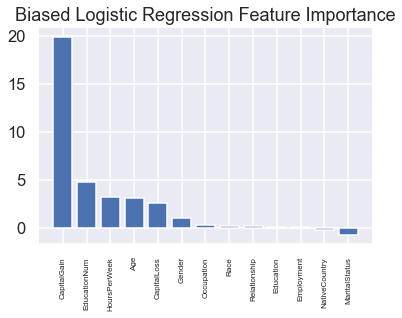

In [18]:
## CODE TO DISPLAY BIASED DATA LOG FEATURE IMPORTANCE
%matplotlib inline
# Display feature importances from the Logistic Regression Classifier
feature_names = list(X_train.columns)
importances   = BiasedLogModel.coef_[0]
# Sort feature importances in descending order
indices       = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names         = [feature_names[i] for i in indices]
# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize = 8) # , after 8
# Create plot title
plt.title("Biased Logistic Regression Feature Importance")
# Show plot
plt.show()

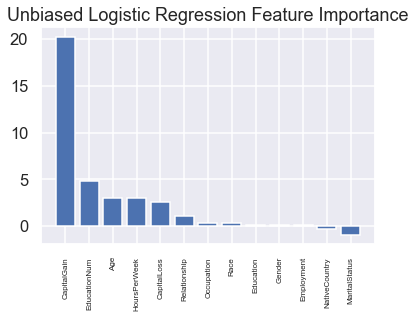

In [19]:
## CODE TO DISPLAY CODE TO DISPLAY UNBIASED LOG FEATURE IMPORTANCE
%matplotlib inline
# Display feature importances from the Logistic Regression Classifier
feature_names = list(X_train.columns)
importances   = UnbiasedLogModel.coef_[0]
# Sort feature importances in descending order
indices       = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names         = [feature_names[i] for i in indices]
# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize = 8)
# Create plot title
plt.title("Unbiased Logistic Regression Feature Importance")
# Show plot
plt.show()

In [20]:
#RFC BIASED DATASET - Obtain model scores & feature importance for Random Forest Classifier 
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
BiasedRfcModel.fit(X_train, y_train)
BiasedRfcPredictions       = BiasedRfcModel.predict(X_test)
BiasedRfcModel_feature_imp = pd.DataFrame(BiasedRfcModel.feature_importances_, index = X_train.columns,
                          columns=['biased importance']).sort_values('biased importance',ascending=False)

In [21]:
#RFC UnBIASED DATASET - Obtain model scores & feature importance for Random Forest Classifier
UnbiasedRfcModel = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=101)
UnbiasedRfcModel.fit(X_train, y_train, sample_weight=Adult_unbiased_bld.instance_weights)
UnbiasedRfcPredictions       = UnbiasedRfcModel.predict(X_test)
UnbiasedRfcModel_feature_imp = pd.DataFrame(UnbiasedRfcModel.feature_importances_, index = X_train.columns,
                          columns=['debiased importance']).sort_values('debiased importance',ascending=False)
print(f"Biased   Random forest validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print(f"Unbiased Random forest validation accuracy: {UnbiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased   Random forest balanced accuracy  : {balanced_accuracy_score(y_test,BiasedRfcPredictions)}")
print(f"Unbiased Random forest balanced accuracy  : {balanced_accuracy_score(y_test, UnbiasedRfcPredictions)}")

Biased   Random forest validation accuracy: 0.8285392568328386
Unbiased Random forest validation accuracy: 0.8234210256935203

Biased   Random forest balanced accuracy  : 0.6664366793843156
Unbiased Random forest balanced accuracy  : 0.6469660970379099


In [22]:
RfcModel_Feature_imp = pd.concat([BiasedRfcModel_feature_imp, UnbiasedRfcModel_feature_imp], axis=1, sort=False)
RfcModel_Feature_imp

,biased importance,debiased importance
CapitalGain,0.276116,0.307049
MaritalStatus,0.166798,0.159039
EducationNum,0.156966,0.183805
Age,0.118725,0.116382
Relationship,0.104281,0.069201
HoursPerWeek,0.058665,0.029958
Education,0.050040,0.075580
CapitalLoss,0.035085,0.038880
Gender,0.023383,0.006696
Occupation,0.005517,0.008997


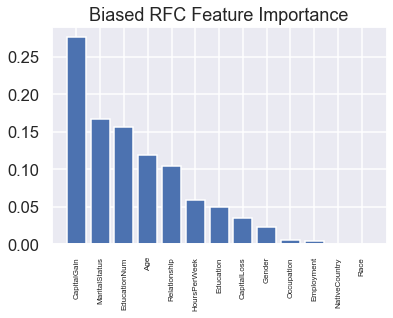

In [23]:
## CODE TO DISPLAY BIASED RFC FEATURE IMPORTANCE
# Display feature importances from the Random Forest Classifier
%matplotlib inline
feature_names = list(X_train.columns)
importances   = BiasedRfcModel.feature_importances_
# Sort feature importances in descending order
indices       = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]
# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize = 8)
# Create plot title
plt.title("Biased RFC Feature Importance")
# Show plot
plt.show()

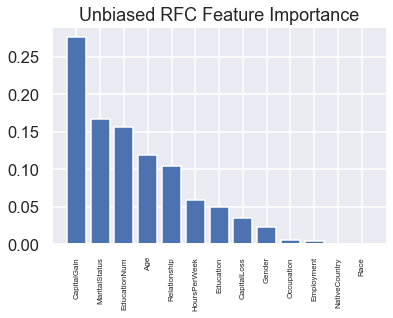

In [24]:
## CODE TO DISPLAY DEBIASED RFC FEATURE IMPORTANCE
# Display feature importances from the Random Forest Classifier
%matplotlib inline
feature_names = list(X_train.columns)
importances   = BiasedRfcModel.feature_importances_
# Sort feature importances in descending order
indices       = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]
# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize = 8)
# Create plot title
plt.title("Unbiased RFC Feature Importance")
# Show plot
plt.show()

In [25]:
#Test for equality of odds. 
Test_bld = BinaryLabelDataset(df=pd.concat((X_test, y_test),axis=1),
                              label_names=[lab], protected_attribute_names=[protected_attr],
                              favorable_label=fav_label, unfavorable_label=unfav_label)
Test_Log_bld = Test_bld.copy(deepcopy=True)
Test_Rfc_bld = Test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [26]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.17167194696848617
Log average_odds_difference:     -0.17167194696848617
 
Rfc average_abs_odds_difference: 0.10542142792681823
Rfc average_odds_difference:     -0.10542142792681823


In [27]:
#Test for equality of odds. 
Test_bld = BinaryLabelDataset(df=pd.concat((X_test, y_test),axis=1),
                              label_names=[lab], protected_attribute_names=[protected_attr],
                              favorable_label=fav_label, unfavorable_label=unfav_label)
Test_Log_bld = Test_bld.copy(deepcopy=True)
Test_Rfc_bld = Test_bld.copy(deepcopy=True)
TestLogPredictions = UnbiasedLogModel.predict(X_test)
TestRfcPredictions = UnbiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [28]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.017051631997912275
Log average_odds_difference:     0.013861517784164935
 
Rfc average_abs_odds_difference: 0.030866255015015585
Rfc average_odds_difference:     0.029944083790433253


Accuracy:


,LogReg,RFC
Biased,0.822909,0.828539
Fair,0.814720,0.823421


AUC:


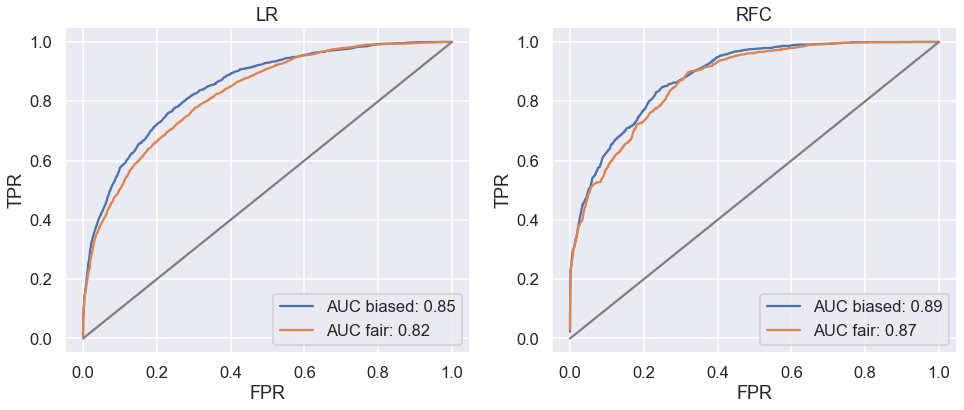

In [29]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 UnbiasedLogModel.score(X_test, y_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              UnbiasedRfcModel.score(X_test, y_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedLogModel.predict_proba(X_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedRfcModel.predict_proba(X_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [30]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

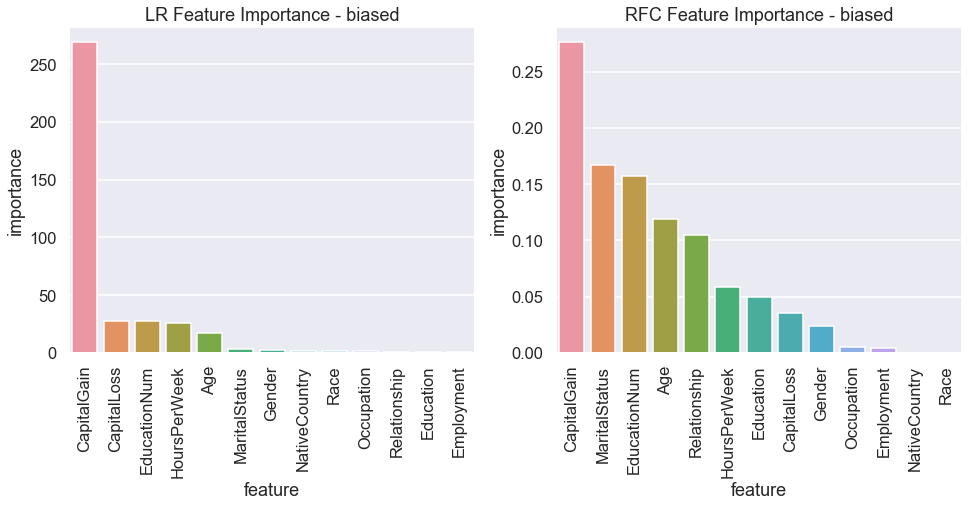

In [31]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

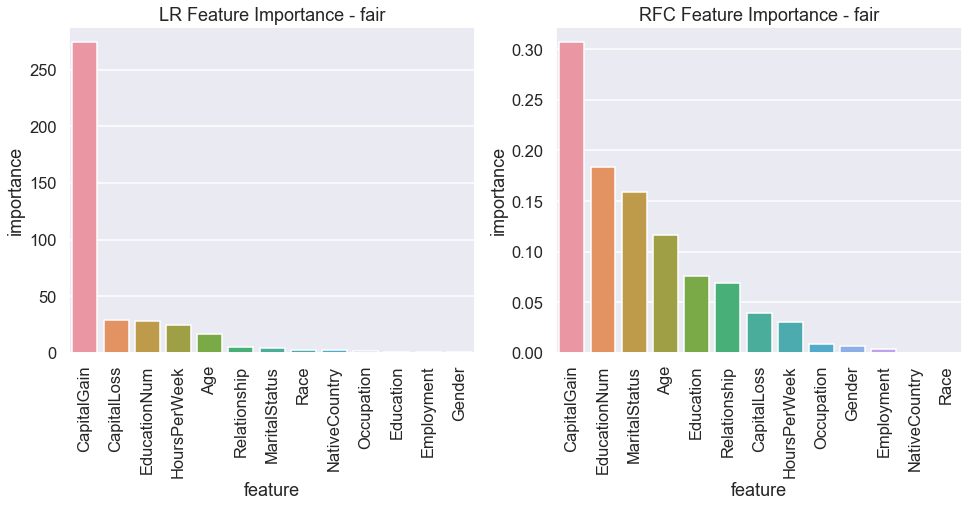

In [32]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogModel, names=X_train.columns.tolist(), 
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [33]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),
                                  label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label,
                                  unfavorable_label=unfav_label)
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy = []
    balanced_accuracy = []
    disp_impact = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

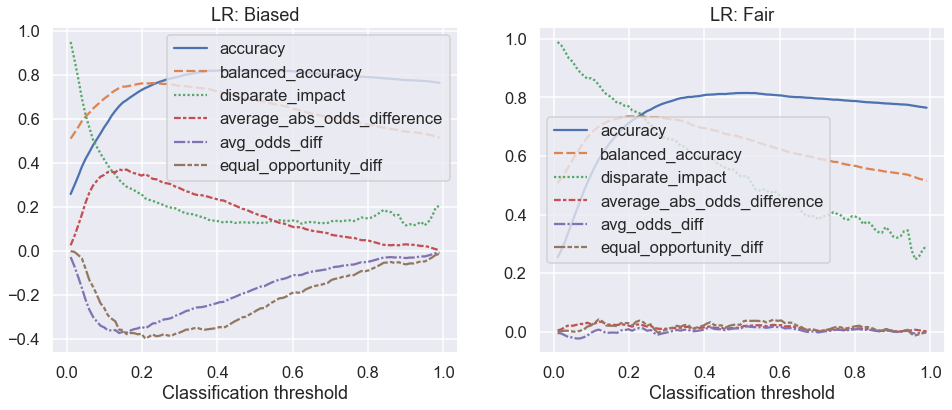

In [34]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogModel, X_test, y_test), ax=ax[1], title="LR: Fair")

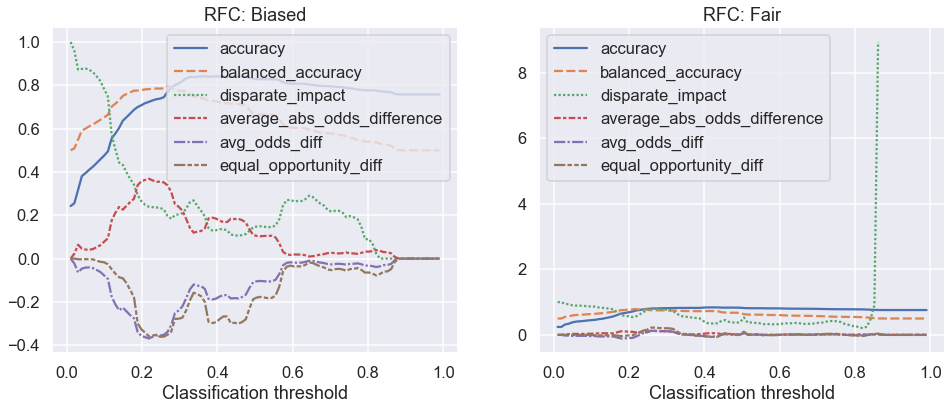

In [35]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcModel, X_test, y_test), ax=ax[1], title="RFC: Fair")

In [36]:
# Finally test whether it is possible to predict the Sensitive Variable from the whole original dataset
Xse = Adult_df.drop(protected_attr,axis=1)
yse = Adult_df[protected_attr]
X_se_train, X_se_test, y_se_train, y_se_test = train_test_split(Xse, yse, test_size = 0.2, random_state = 101)

# Scale the Test and Train dataframes 
scaler = MinMaxScaler(copy=False)
X_se_train = pd.DataFrame(scaler.fit_transform(X_se_train.values), columns=X_se_train.columns, index=X_se_train.index)
X_se_test  = pd.DataFrame(scaler.fit_transform(X_se_test.values),  columns=X_se_test.columns,  index=X_se_test.index)

Se_UnbiasedLogModel = LogisticRegression(random_state=101)
Se_UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_UnbiasedLogModel.fit(X_se_train, y_se_train,sample_weight=Adult_unbiased_bld.instance_weights) 
Se_UnbiasedRfcModel.fit(X_se_train, y_se_train,sample_weight=Adult_unbiased_bld.instance_weights) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_UnbiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_UnbiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7685535878800287
Biased Random Forest       validation accuracy: 0.8023339133995291

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.7019187773380953
Biased Random Forest       balanced accuracy  : 0.7566385592116929


In [37]:
# Lastly get the number of labels from the modified training dataset
print('Training Before - Income value counts:')
print(Adult_df.Income.value_counts())
print('Training Before - Gender value counts:')
print(Adult_df.Gender.value_counts())

Training Before - Income value counts:
0.0    37155
1.0    11687
Name: Income, dtype: int64
Training Before - Gender value counts:
1.0    32650
0.0    16192
Name: Gender, dtype: int64
